# Recurrent Neural Net w/Embedding
---
Obviously we can also do a recurrent net but with indexes as input rather than one hot-encoding, in this case we will create embeddings and run the output of the embedding through the recurrent layer.

Note that each value of the timestep will be processed through the same embedding, we will not have an embedding per position. For instance, if we have a gender embedding, then the each gender index in the series will be processed/encoded through one and the same embedding.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import datetime as dt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../../data/bs140513_032310.csv'

## Define Features

### Define Base Features

In [5]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

td_base = ft.TensorDefinition('all', [step, customer, age, gender, merchant, category, amount, fraud])

### Define Derived Features
For this example we will encode everything as an index/categorical feature. 

The features that change per each payment (age, gender and amount) will form a series (3 dimensional tensor). It will be **key'ed** on the merchant, the series will contain the last x payments including the specific merchant.

The features that are referential to the merchant, (merchant id and category) will be fed as a standard 2 dimensional tensor.

In [6]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

# Categorical Features
amount_bin   = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
age_i        = ft.FeatureIndex('age_i', ft.FEATURE_TYPE_INT_8, age)
gender_i     = ft.FeatureIndex('gender_i', ft.FEATURE_TYPE_INT_8, gender)
merchant_i   = ft.FeatureIndex('merchant_i', ft.FEATURE_TYPE_INT_8, merchant)
category_i   = ft.FeatureIndex('category_i', ft.FEATURE_TYPE_INT_8, category)

# Label Feature
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

stacked_series = ft.FeatureSeriesStacked(
    'stacked', ft.FEATURE_TYPE_INT_8, [amount_bin, age_i, gender_i], 5, merchant
)

td_series      = ft.TensorDefinition('stacked', [stacked_series])
td_referential = ft.TensorDefinition('referential', [merchant_i, category_i])
td_label       = ft.TensorDefinition('label', [fraud_label])

# Note we 
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_series, td_referential, td_label), file, time_feature=date_time, inference=False)

2023-06-18 09:36:40.671 eng1n3.common.engine           INFO     Start Engine...
2023-06-18 09:36:40.672 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-18 09:36:40.672 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-18 09:36:40.673 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../../data/bs140513_032310.csv
2023-06-18 09:36:41.264 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-18 09:36:41.266 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked using 1 process(es)
2023-06-18 09:36:41.372 e...ureseriesstackedprocessor  INFO     Returning series of type int8.
2023-06-18 09:36:41.373 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 5, 3)]


In [8]:
ti

TensorInstance with shapes: ((594643, 5, 3), (594643, 2), (594643, 1))

## Create Data-Sets and Loaders

In [9]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 5, 3), (464643, 2), (464643, 1))
((30000, 5, 3), (30000, 2), (30000, 1))
((100000, 5, 3), (100000, 2), (100000, 1))


## Create LSTM Model
This model is going to be a bit more complicated than the previous ones. We are going to have 2 heads as described earlier. `Head0` will be the series, `Head1` the referential data.

We will push the Head1 through an `LSTM` recurrent layer. The LSTM will return the output at each timestep, so will have shape BxSxF. Of that LSTM rank-3 tensor, we select the last output. And then concatenate the Head1 to that LSTM last output, and feed the combined flattened output through a set of linear layers.

In [10]:
class BankSimLSTM(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimLSTM, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        lstm_size = 8 
        # The first head is the Series. Create an LSTM to process it. Use Batch first to get a BxSxF output!
        self.lstm = nn.LSTM(self.heads[0].output_size, lstm_size, batch_first=True)
        
        # Set of layers
        self.layers = mp.LinLayer(
            input_size=self.heads[1].output_size+lstm_size, layer_sizes=((16,8)), dropout=0.0, bn_interval=2
        )       

        # And a tail layer. For a binary classifier this adds a linear layer to output a size of 1 + Sigmoid
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Run heads logic
        h0 = self.heads[0](x[0])
        h1 = self.heads[1](x[1])
        # Pass head 0 (the series) through the LSTM.
        o, _ = self.lstm(h0)
        # Take the final output
        o = o[:, -1, :]
        # Concatenate to head 1.
        o = torch.cat((h1, o), dim=1)
        # Run through linear layers.
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimLSTM(
  Number of parameters : 3876. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=SeriesTD, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(
      Name=referential, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(51, 25)
          (1): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (lstm): LSTM(25, 8, batch_first=True)
  (layers): LinLayer(
    (layers): Sequential(
      (lin_layer_01): Linear(in_features=41, out_features=16, bias=True)
      (lin_act_01): ReLU()
      (lin_layer_02): Linear(in_features=16, out_features=8, bias=True)
      (lin_bn_02): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine

Graphically this model looks more or less like  this; The final linear layers have been omitted.

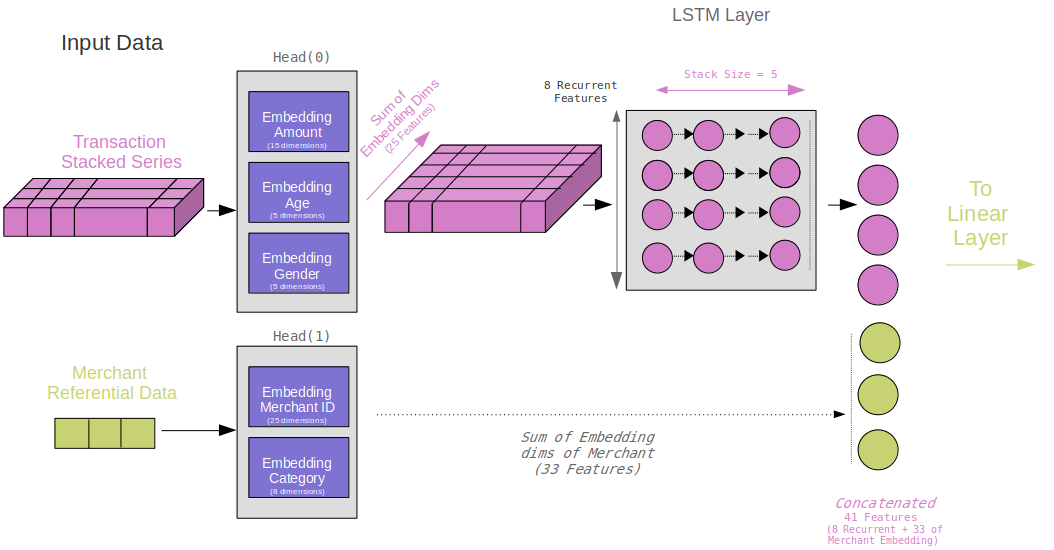

## Train

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 335.34it/s]                                                    


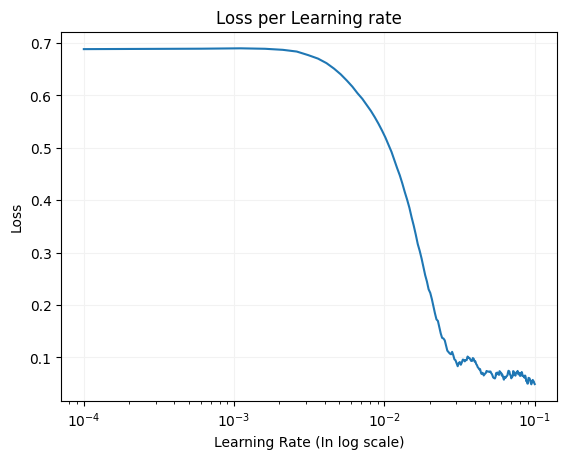

In [11]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [12]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=1e-2)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:07<00:00, 538.11it/s, t_loss=0.0354, t_acc=0.989, v_loss=0.0262, v_acc=0.99]     


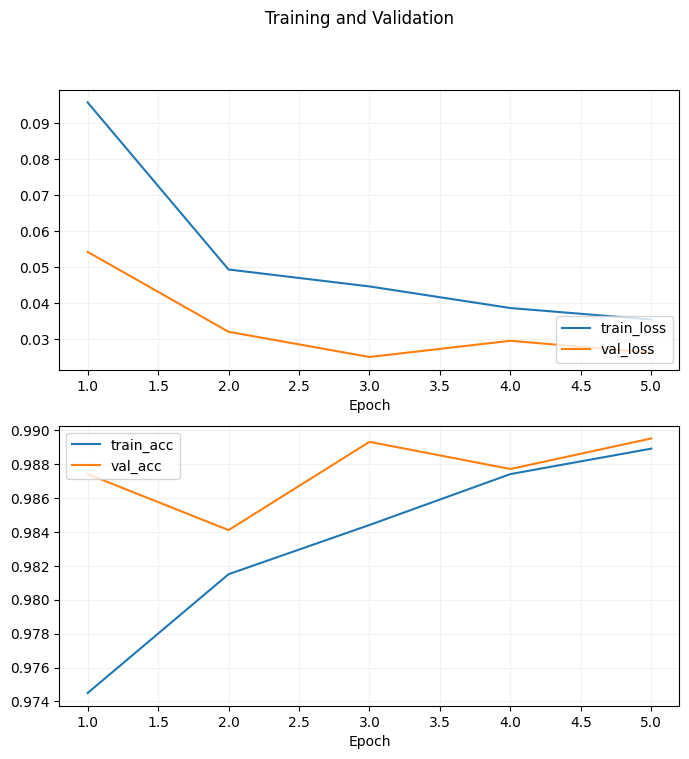

In [13]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

With the embeddings the LSTM model performs better, it feels like the embeddings provide an abstraction with which the model probably overfits less. This model performs fairly well, and much like the previous LSTM model, it does feel like it gets a better handle on the False Postives. Though we can't be sure that is actually the series that makes it so, there could be other factors at play.

Testing in 782 steps: 100%|█████████████████| 782/782 [00:00<00:00, 1224.30it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.53      0.96      0.68      1074

    accuracy                           0.99    100000
   macro avg       0.76      0.98      0.84    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9988
ap score  : 0.9275
-----------------------------------------------------


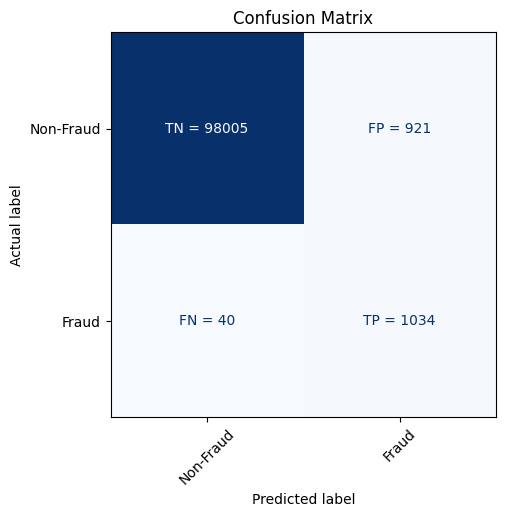

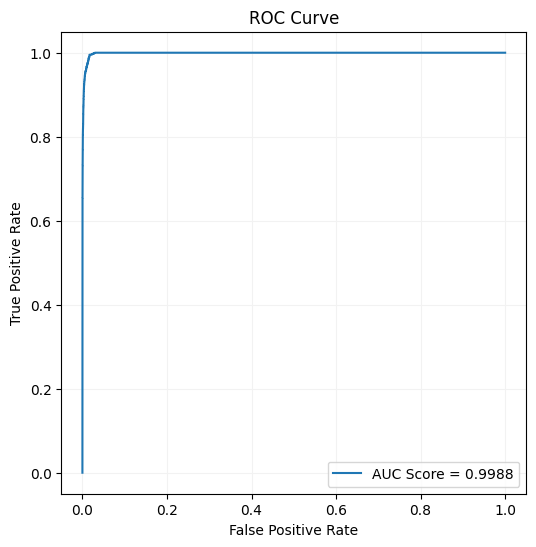

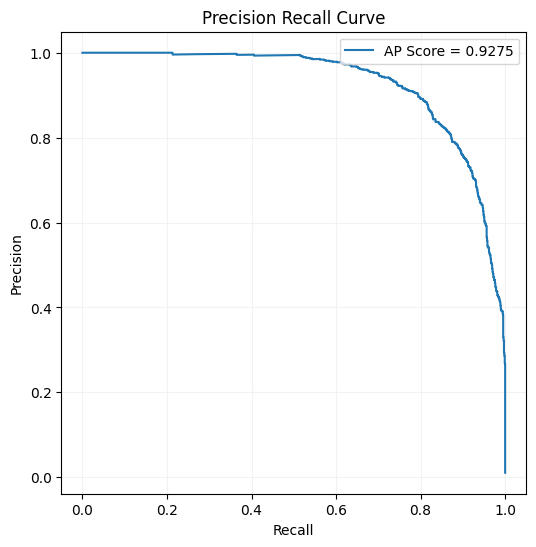

In [14]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

# Conclusion
The second LSTM model with embeddings did not exhibit the weird shape of the AUC curve cause by some fairly big mispredictions the previous model made. The most likely cause for this difference is that the embeddings provide an abstraction layer and the dropout in the embedding provide some randomness as compared to the one-hot model